# Project 4 - Stretch Goal 1
## Ayden Shankman and Gavri Kepets
Implementing a basic Tree Algorithm from scratch for classification and regression that can use several loss functions: entropy, gini index, misclassification, and MSE

In [ ]:
from sklearn.datasets import fetch_california_housing
import sklearn.datasets
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from statistics import mean, mode

Node Class

In [ ]:
class Node():
    def __init__(self, feature_index=None, thresh=None, left=None, right=None, info_gain=None, value=None):        
        
        # Decision Node
        self.feat_index = feature_index
        self.thresh = thresh
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # Leaf Node
        self.value = value

Functions for Building Decision Tree

In [ ]:
def build_tree(data_train, curr_depth, max_depth, loss_func, tree_type):

  if(curr_depth < max_depth):
    best_split = get_best_split(data_train, loss_func, tree_type) # get best split
    if best_split["info_gain"] > 0: # if there's impurity
      left_subtree = build_tree(best_split["dataset_left"], curr_depth+1, max_depth, loss_func, tree_type) # build left subtree 
      right_subtree = build_tree(best_split["dataset_right"], curr_depth+1, max_depth, loss_func, tree_type) # build right subtree
      
      return Node(best_split["feat_index"], best_split["thresh"], 
                  left_subtree, right_subtree, best_split["info_gain"])

  # If there's no splitting to be done, make a leaf node
  return Node(value = get_leaf_value(data_train[:,-1], tree_type))

# Function to return the best split info
def get_best_split(data_train, loss_func, tree_type):
  num_feat = data_train.shape[1] - 1
  max_info_gain = -float("inf")
  min_info_gain = float("inf")

  best_split = {}
  best_split["info_gain"] = 0

  for feat_index in range(num_feat): # loop through features
    X_curr = data_train[:,feat_index]
    for thresh in np.unique(X_curr):  # loop through unique values in feature
      # Split data into left and right subsets
      left_data = np.array([row for row in data_train if row[feat_index]<=thresh])
      right_data = np.array([row for row in data_train if row[feat_index]>thresh])
      # Make sure both subsets aren't empty
      if(len(left_data) > 0 and len(right_data) > 0):

        curr_info_gain = info_gain(left_data[:,-1], right_data[:,-1], data_train[:,-1], loss_func) # get info gain
        
        # For classification
        if(tree_type == "class"):

          if curr_info_gain > max_info_gain:
            max_info_gain = curr_info_gain
            best_split["feat_index"] = feat_index
            best_split["thresh"] = thresh
            best_split["dataset_left"] = left_data
            best_split["dataset_right"] = right_data
            best_split["info_gain"] = curr_info_gain
        
        # For regression
        elif(tree_type == "regress"):

          if curr_info_gain < min_info_gain:
            min_info_gain = curr_info_gain
            best_split["feat_index"] = feat_index
            best_split["thresh"] = thresh
            best_split["dataset_left"] = left_data
            best_split["dataset_right"] = right_data
            best_split["info_gain"] = curr_info_gain
        
  return best_split

# Function to calculate info gain of split
def info_gain(Y_left, Y_right, Y, gain_func):

  if gain_func == mse:
    return mse(Y_left, Y_right)

  # get weights of each side of split
  weight_l = len(Y_left)/len(Y)
  weight_r = len(Y_right)/len(Y)

  # Info gain equation
  return gain_func(Y) - (weight_l*gain_func(Y_left) + weight_r*gain_func(Y_right))

# Calculate entropy of dataset
def entropy(Y):
  class_labs = np.unique(Y)
  entropy = 0
  for cls in class_labs:
    prob_cls = len(Y[Y == cls])/len(Y)
    entropy += (-prob_cls * np.log2(prob_cls))
  return entropy

# Calculate Gini index of dataset
def gini(Y):
  class_labs = np.unique(Y)
  gini = 0
  for cls in class_labs:
    prob_cls = len(Y[Y == cls])/len(Y)
    gini += prob_cls**2
  return 1-gini

# Calculate misclassification rate of dataset
def misclass(Y):
  y_pred = mode(Y)
  return len(Y[Y != y_pred])/len(Y)

# Calculate MSE of split
def mse(Y_left, Y_right):
  return ((Y_left - Y_left.mean())**2).sum() + ((Y_right - Y_right.mean())**2).sum()

# Calculates value at leaf node
def get_leaf_value(Y, tree_type):
  Y = list(Y)
  if tree_type == "regress":
    return mean(Y)
  return max(Y, key=Y.count)

# Prints tree
def print_tree(tree, indent = "  "):

  if tree.value is not None:
    print(tree.value)
  
  else:
    print("X_"+str(tree.feat_index), "<=", tree.thresh, "?", tree.info_gain)
    print("%sleft:" % (indent), end="")
    print_tree(tree.left, indent + indent)
    print("%sright:" % (indent), end="")
    print_tree(tree.right, indent + indent)

# Predicts values of test set on a tree
def predict(X_test, tree):
  predictions = [make_predict(row, tree) for row in X_test]
  return predictions

def make_predict(X_test_row, tree):
  if tree.value != None:
    return tree.value
  feature_val = X_test_row[tree.feat_index]
  if feature_val <= tree.thresh:
    return make_predict(X_test_row, tree.left)
  else:
    return make_predict(X_test_row, tree.right)

Decision Tree Classification

--------------------------------
Baseline MSE: 0.42105263157894735
--------------------------------


100%|██████████| 7/7 [05:24<00:00, 46.41s/it]


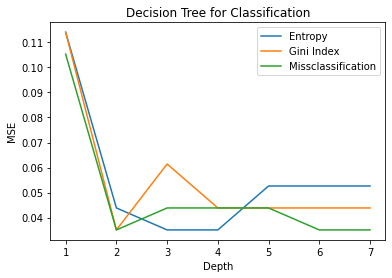

In [ ]:
# Breast Cancer Dataset
breast_cancer_df = sklearn.datasets.load_breast_cancer() 
X_cancer = pd.DataFrame(breast_cancer_df["data"], columns = breast_cancer_df["feature_names"])
Y_cancer = breast_cancer_df["target"]

X_train, X_test, Y_train, Y_test = train_test_split(X_cancer, Y_cancer, test_size=0.2) # Split data into training and testing
X_train["label"] = Y_train

entropy_loss = []
gini_loss = []
miss_loss = []
max_depth = 7

# Get basline MSE using mode of training data
Y_pred = [mode(list(Y_train))]*len(Y_test)
baseline = mean_squared_error(Y_test,Y_pred)
print("--------------------------------")
print('Baseline MSE: ' + str(baseline))
print("--------------------------------")

# Build trees with different loss functions of increasing depth
for i in tqdm(range(1,max_depth+1)):

  # Tree using entropy  
  tree_entropy = build_tree(X_train.to_numpy(), curr_depth = 0, max_depth = i, loss_func = entropy, tree_type = "class")
  Y_pred_ent = predict(X_test.to_numpy(), tree_entropy)
  entropy_loss.append(mean_squared_error(Y_test, Y_pred_ent))
  
  # Tree using gini index  
  tree_gini = build_tree(X_train.to_numpy(), curr_depth = 0, max_depth = i, loss_func = gini, tree_type = "class")
  Y_pred_gini = predict(X_test.to_numpy(), tree_gini)
  gini_loss.append(mean_squared_error(Y_test, Y_pred_gini))

  # Tree using misclassification
  tree_miss = build_tree(X_train.to_numpy(), curr_depth = 0, max_depth = i, loss_func = misclass, tree_type = "class")
  Y_pred_miss = predict(X_test.to_numpy(), tree_miss)
  miss_loss.append(mean_squared_error(Y_test, Y_pred_miss))

# Plot each tree at each depth against baseline
plt.figure()
plt.plot(list(range(1,max_depth+1)), entropy_loss)
plt.plot(list(range(1,max_depth+1)), gini_loss)
plt.plot(list(range(1,max_depth+1)), miss_loss)
plt.title("Decision Tree for Classification")
plt.ylabel("MSE")
plt.xlabel("Depth")
plt.legend(['Entropy', "Gini Index", "Missclassification"])


Decision Tree Regression

--------------------------------
Baseline MSE: 0.6691347413786977
--------------------------------


100%|██████████| 7/7 [00:42<00:00,  6.08s/it]


Text(0.5, 0, 'Depth')

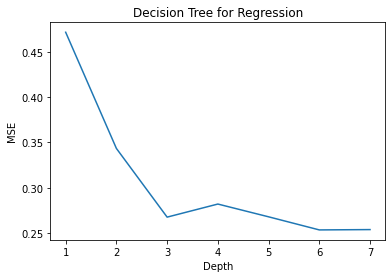

In [ ]:
# California Housing Prices Dataset
california_housing = fetch_california_housing(as_frame=True)

X_cal = pd.DataFrame(california_housing["data"], columns = california_housing["feature_names"])[:1000]
Y_cal = california_housing["target"][:1000]

X_train, X_test, Y_train, Y_test = train_test_split(X_cal, Y_cal, test_size=0.2) # Split data into training and testing
X_train["target"] = Y_train

# Get basline MSE using mean of training data
Y_pred = [mean(list(Y_train))]*len(Y_test)
baseline = mean_squared_error(Y_test,Y_pred)
print("--------------------------------")
print('Baseline MSE: ' + str(baseline))
print("--------------------------------")

max_depth = 7
mse_loss = []

# Build regression tree using MSE as loss function with increasing depths 
for i in tqdm(range(1,max_depth+1)):
  tree = build_tree(X_train.to_numpy(), curr_depth = 0, max_depth = i, loss_func = mse, tree_type = "regress")
  Y_pred = predict(X_test.to_numpy(), tree)
  mse_loss.append(mean_squared_error(Y_test, Y_pred))

plt.figure()
plt.plot(list(range(1,max_depth+1)), mse_loss)
plt.title("Decision Tree for Regression")
plt.ylabel("MSE")
plt.xlabel("Depth")